# LAB3: Sparsity
Authors: 

    Mathurin Massias (mathurin.massias@gmail.com)
    
    Giacomo Meanti  

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from scipy.io import loadmat

from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split

from lab3_utils import create_random_data

# Warm-up part

## Dataset generation and model fitting

In [2]:
def train_test_data(n_samples, n_features, n_informative_features, 
                    noise_level):
    """Util function to generate and split random data.
    See the docstring of create_random_data for more details.
    """
    X, y = create_random_data(n_samples, n_features, n_informative_features, 
                              noise_level=noise_level)
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    train_size = 0.8  # proportion of dataset used for training
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, shuffle=False, train_size=train_size)
    return X_train, X_test, y_train, y_test

### Noiseless data

First, generate data without noise: $y = X \beta^\star$, where $\beta^\star$ has `n_informative_features` non-zero entries and $X$ has shape (n_samples, n_features).

We split it into testing and training parts.

In [3]:
n_samples = 100
n_features = 200
n_informative_features = 50

# first, use noiseless data, split in train and test/validation parts
X_train, X_test, y_train, y_test = train_test_data(
    n_samples, n_features, n_informative_features, noise_level=0.)
print("Training dataset shape:", X_train.shape)
print("Testing dataset shape:", X_test.shape)

X shape: (100, 200)
y shape: (100,)
Training dataset shape: (80, 200)
Testing dataset shape: (20, 200)


In sklearn, the objective function of the `ElasticNet` optimization is:
$$\frac{1}{2 \times \text{n_samples}} \Vert y - X \beta \Vert_2^2 + \alpha \times \left( \text{l1_ratio} \times \Vert \beta \Vert_1 + \frac{1 - \text{l1_ratio}}{2} \Vert \beta \Vert_2^2\right)$$
you can get pure L1 regularization (the LASSO estimator) by setting `l1_ratio` to $1$, and pure L2 regularization (ridge regression) by setting it to $0$.

For more information, read the docstring after displaying it in the next cell (you can close the documentation popup afterwards by clicking on the cross or hitting Esc).

In [4]:
ElasticNet?

Init signature:
ElasticNet(
    alpha=1.0,
    *,
    l1_ratio=0.5,
    fit_intercept=True,
    normalize=False,
    precompute=False,
    max_iter=1000,
    copy_X=True,
    tol=0.0001,
    warm_start=False,
    positive=False,
    random_state=None,
    selection='cyclic',
)
Docstring:     
Linear regression with combined L1 and L2 priors as regularizer.

Minimizes the objective function::

        1 / (2 * n_samples) * ||y - Xw||^2_2
        + alpha * l1_ratio * ||w||_1
        + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2

If you are interested in controlling the L1 and L2 penalty
separately, keep in mind that this is equivalent to::

        a * L1 + b * L2

where::

        alpha = a + b and l1_ratio = a / (a + b)

The parameter l1_ratio corresponds to alpha in the glmnet R package while
alpha corresponds to the lambda parameter in glmnet. Specifically, l1_ratio
= 1 is the lasso penalty. Currently, l1_ratio <= 0.01 is not reliable,
unless you supply your own sequence of alpha.

Read

In [5]:
# instantiate a classifier with arbitrary values for L1 and L2 penalization
clf = ElasticNet(alpha=0.01, l1_ratio=0.5)

In [9]:
# fit the model and print its first coefficients
# beware that sklearn fits an intercept by default
clf.fit(X_train, y_train)
print("50 first coefficients of estimated w:\n", clf.coef_[:50])
print("Intercept: %f" % clf.intercept_)
print("Nonzero coefficients: %d out of %d" % ((clf.coef_ != 0.).sum(), clf.coef_.shape[0]))
print("Training error: %.2e" % np.mean((y_train - clf.predict(X_train)) ** 2))
# TODO compute testing error on left out data
print("Testing error: %.4f" % np.mean((y_test - clf.predict(X_test)) ** 2))
# TODO bonus: why is clf.predict(X_train) not equal to X_train @ clf.coef_?

50 first coefficients of estimated w:
 [-0.          0.         -0.         -0.         -0.         -0.
  0.          0.         -0.          0.         -0.01576661 -0.02595919
  0.         -0.         -0.         -0.          0.         -0.02150962
  0.         -0.          0.          0.         -0.         -0.
  0.         -0.          0.00290123 -0.          0.          0.
  0.00122145  0.          0.0108256  -0.005127    0.         -0.
 -0.          0.          0.         -0.         -0.         -0.
 -0.          0.          0.00385302 -0.         -0.         -0.
  0.          0.        ]
Intercept: -0.004575
Nonzero coefficients: 38 out of 200
Training error: 7.95e-04
Testing error: 0.0040


#### TODO bonus: why is clf.predict(X_train) not equal to X_train @ clf.coef_?
**Because in  *X_train @ clf.coef_* the intecept is missing. The correct formula is *clf.intecept + (X_train @ clf.coef_)***

For a fixed $\alpha$, test the influence of l1_ratio on the sparsity of the solution and on the behaviors of the train and test errors:

Text(0.5, 0, 'l1_ratio')

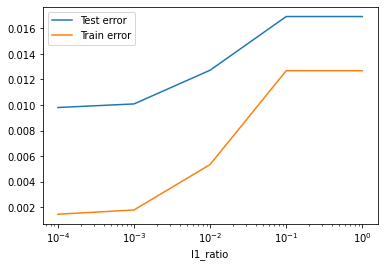

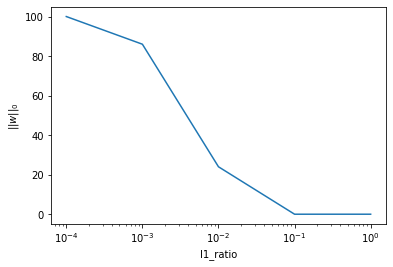

In [68]:
l1_ratios = [0.0001, 0.001, 0.01, 0.1, 1.0]  # TODO choose your own values between 0 and 1

train_errs = np.zeros(len(l1_ratios))
test_errs = np.zeros_like(train_errs)
sparsity = np.zeros_like(train_errs)

for i, l1_ratio in enumerate(l1_ratios):
    clf = ElasticNet(alpha=1, l1_ratio=l1_ratio)# TODO; you may need to tune alpha a bit too.
    # TODO fit the model on train data
    clf.fit(X_train, y_train)
    # TODO compute train and test errors
    train_errs[i] = np.mean((y_train - clf.predict(X_train)) ** 2)
    test_errs[i] = np.mean((y_test - clf.predict(X_test)) ** 2)
    sparsity[i] = len(clf.coef_[clf.coef_>0]) # number of non-zero elements in clf.coef_
    
plt.figure()
plt.plot(l1_ratios, test_errs, label='Test error')
plt.plot(l1_ratios, train_errs, label='Train error')
plt.xscale('log')
plt.xlabel("l1_ratio")
plt.legend()

plt.figure()
plt.plot(l1_ratios, sparsity)
plt.xscale('log')
plt.ylabel(r'$||w||_0$')
plt.xlabel('l1_ratio')

[1.00000000e-04 1.45634848e-04 2.12095089e-04 3.08884360e-04
 4.49843267e-04 6.55128557e-04 9.54095476e-04 1.38949549e-03
 2.02358965e-03 2.94705170e-03 4.29193426e-03 6.25055193e-03
 9.10298178e-03 1.32571137e-02 1.93069773e-02 2.81176870e-02
 4.09491506e-02 5.96362332e-02 8.68511374e-02 1.26485522e-01
 1.84206997e-01 2.68269580e-01 3.90693994e-01 5.68986603e-01
 8.28642773e-01 1.20679264e+00 1.75751062e+00 2.55954792e+00
 3.72759372e+00 5.42867544e+00 7.90604321e+00 1.15139540e+01
 1.67683294e+01 2.44205309e+01 3.55648031e+01 5.17947468e+01
 7.54312006e+01 1.09854114e+02 1.59985872e+02 2.32995181e+02
 3.39322177e+02 4.94171336e+02 7.19685673e+02 1.04811313e+03
 1.52641797e+03 2.22299648e+03 3.23745754e+03 4.71486636e+03
 6.86648845e+03 1.00000000e+04]


Text(0.5, 0, 'alpha')

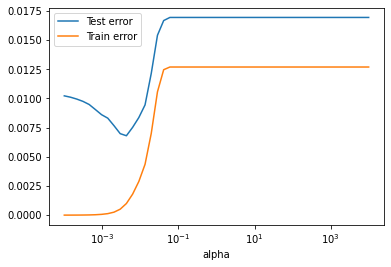

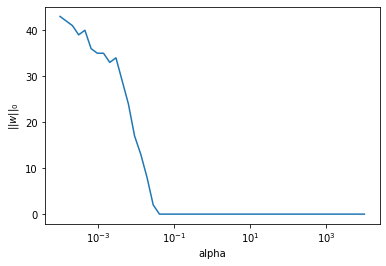

In [67]:
# TODO do the same for the influence of alpha, with a fixed l1_ratio
# What happens when alpha becomes too big?
alphas = np.geomspace(1e-4, 1e4, num=50)
print(alphas)
# TODO plot train/test curve, sparsity curve
train_errs = np.zeros(len(alphas))
test_errs = np.zeros_like(train_errs)
sparsity = np.zeros_like(train_errs)

for i, alpha in enumerate(alphas):
    clf = ElasticNet(alpha=alpha, l1_ratio=1)# TODO; you may need to tune alpha a bit too.
    # TODO fit the model on train data
    clf.fit(X_train, y_train)
    # TODO compute train and test errors
    train_errs[i] = np.mean((y_train - clf.predict(X_train)) ** 2)
    test_errs[i] = np.mean((y_test - clf.predict(X_test)) ** 2)
    sparsity[i] = len(clf.coef_[clf.coef_>0]) # number of non-zero elements in clf.coef_
    
plt.figure()
plt.plot(alphas, test_errs, label='Test error')
plt.plot(alphas, train_errs, label='Train error')
plt.xlabel("alpha")
plt.xscale('log')
plt.legend()

plt.figure()
plt.plot(alphas, sparsity)
plt.xscale('log')
plt.ylabel(r'$||w||_0$')
plt.xlabel('alpha')

**For alpha near 0.1 all the coefficient are zero**

### Noisy data
Do the same analysis as above, this time when the observations $y$ are corrupted by additive Gaussian noise:
$$y = X \beta^\star + \varepsilon$$

In [43]:
# TODO check again the influence of regularization when there is noise in the data.
noise_level = 0.5

X_train, X_test, y_train, y_test = train_test_data(
    n_samples, n_features, n_informative_features, 
    noise_level=noise_level)
# TODO: plot train/test curve and sparsity curve

X shape: (100, 200)
y shape: (100,)


Text(0.5, 0, 'l1_ratio')

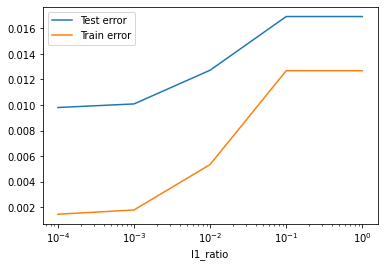

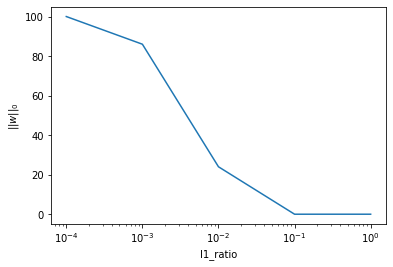

In [69]:
l1_ratios = [0.0001, 0.001, 0.01, 0.1, 1.0]  # TODO choose your own values between 0 and 1

train_errs = np.zeros(len(l1_ratios))
test_errs = np.zeros_like(train_errs)
sparsity = np.zeros_like(train_errs)

for i, l1_ratio in enumerate(l1_ratios):
    clf = ElasticNet(alpha=1, l1_ratio=l1_ratio)# TODO; you may need to tune alpha a bit too.
    # TODO fit the model on train data
    clf.fit(X_train, y_train)
    # TODO compute train and test errors
    train_errs[i] = np.mean((y_train - clf.predict(X_train)) ** 2)
    test_errs[i] = np.mean((y_test - clf.predict(X_test)) ** 2)
    sparsity[i] = len(clf.coef_[clf.coef_>0]) # number of non-zero elements in clf.coef_
    
plt.figure()
plt.plot(l1_ratios, test_errs, label='Test error')
plt.plot(l1_ratios, train_errs, label='Train error')
plt.xscale('log')
plt.xlabel("l1_ratio")
plt.legend()

plt.figure()
plt.plot(l1_ratios, sparsity)
plt.xscale('log')
plt.ylabel(r'$||w||_0$')
plt.xlabel('l1_ratio')

[0.0001     0.00011514 0.00013257 0.00015264 0.00017575 0.00020236
 0.000233   0.00026827 0.00030888 0.00035565 0.00040949 0.00047149
 0.00054287 0.00062506 0.00071969 0.00082864 0.0009541  0.00109854
 0.00126486 0.00145635 0.00167683 0.0019307  0.002223   0.00255955
 0.00294705 0.00339322 0.00390694 0.00449843 0.00517947 0.00596362
 0.00686649 0.00790604 0.00910298 0.01048113 0.01206793 0.01389495
 0.01599859 0.0184207  0.02120951 0.02442053 0.02811769 0.03237458
 0.03727594 0.04291934 0.04941713 0.05689866 0.06551286 0.0754312
 0.08685114 0.1       ]


Text(0.5, 0, 'alpha')

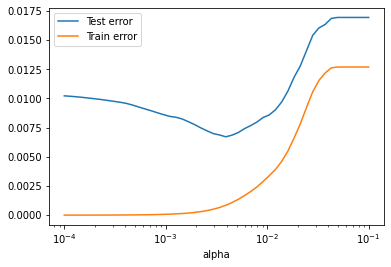

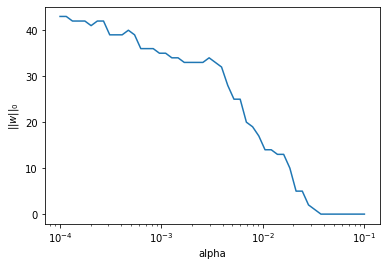

In [70]:
alphas = np.geomspace(1e-4, 1e-1, num=50)
print(alphas)
# TODO plot train/test curve, sparsity curve
train_errs = np.zeros(len(alphas))
test_errs = np.zeros_like(train_errs)
sparsity = np.zeros_like(train_errs)

for i, alpha in enumerate(alphas):
    clf = ElasticNet(alpha=alpha, l1_ratio=1)# TODO; you may need to tune alpha a bit too.
    # TODO fit the model on train data
    clf.fit(X_train, y_train)
    # TODO compute train and test errors
    train_errs[i] = np.mean((y_train - clf.predict(X_train)) ** 2)
    test_errs[i] = np.mean((y_test - clf.predict(X_test)) ** 2)
    sparsity[i] = len(clf.coef_[clf.coef_>0]) # number of non-zero elements in clf.coef_
    
plt.figure()
plt.plot(alphas, test_errs, label='Test error')
plt.plot(alphas, train_errs, label='Train error')
plt.xscale('log')
plt.xlabel("alpha")
plt.legend()

plt.figure()
plt.plot(alphas, sparsity)
plt.xscale('log')
plt.ylabel(r'$||w||_0$')
plt.xlabel('alpha')

### Bonus 
An alternative formulation/parametrization of the ElasticNet objective is:
$$\frac{1}{2 \times \text{n_samples}} \Vert y - X \beta \Vert_2^2 + a \Vert \beta \Vert_1 + \frac{b}{2} \Vert \beta \Vert_2^2$$

Express $\alpha$ and l1_ratio as functions of $a$ and $b$.

For a fixed value of $a$, fit the model with increasing values of $b$. How is the sparsity of the solutions affected?  

Text(0.5, 0, 'b_values')

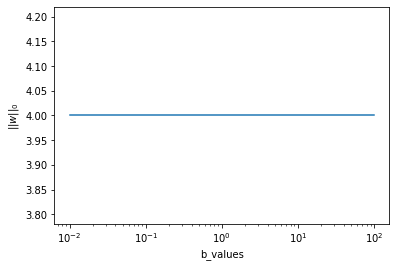

In [93]:
# TODO how is the sparsity affected if you increase the L2 regularization ?
a = 1
b_values = [0.01, 0.1, 1.0, 100]
sparsity = np.zeros(len(b_values))
for i, b in enumerate(b_values):
    alpha = 0.1
    l1_ratio = 0.4
    clf = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    clf.fit(X_train, y_train)
    sparsity[i] = len(clf.coef_[clf.coef_>0])
# TODO plot

plt.figure()
plt.plot(b_values, sparsity)
plt.xscale('log')
plt.ylabel(r'$||w||_0$')
plt.xlabel('b_values')

**All coefficient zero, Underfitting**

### Influence of dataset size
Observe that the datafitting term is normalized by n_samples, hence it should not grow when the dataset becomes taller (`n_features` is fixed, `n_samples` increases).

Vary one of `n_samples`, `n_features` and `n_informative_features` to observe their influence on the model. What happens when `n_samples` becomes greater that `n_informative_features` ?

X shape: (10, 200)
y shape: (10,)
X shape: (100, 200)
y shape: (100,)
X shape: (150, 200)
y shape: (150,)
X shape: (300, 200)
y shape: (300,)
X shape: (500, 200)
y shape: (500,)
X shape: (1000, 200)
y shape: (1000,)
X shape: (1500, 200)
y shape: (1500,)


Text(0.5, 0, 'n_samples')

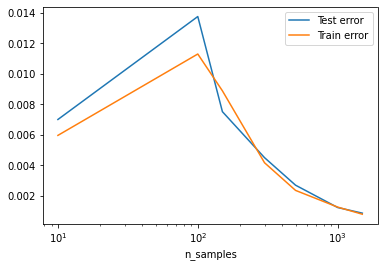

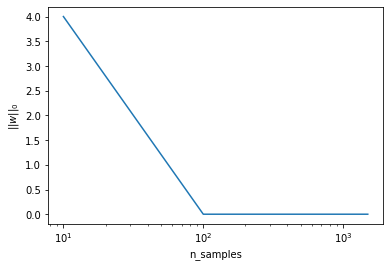

In [74]:
n_samples = [10, 100, 150, 300, 500, 1000, 1500]
n_features = 200
n_informative_features = 120

# TODO
train_errs = np.zeros(len(n_samples))
test_errs = np.zeros_like(train_errs)
sparsity = np.zeros_like(train_errs)

for i, samples in enumerate(n_samples):
    X_train, X_test, y_train, y_test = train_test_data(samples, n_features, n_informative_features, noise_level=0.5)
    clf = ElasticNet(alpha=0.1, l1_ratio=0.5)# TODO; you may need to tune alpha a bit too.
    # TODO fit the model on train data
    clf.fit(X_train, y_train)
    # TODO compute train and test errors
    train_errs[i] = np.mean((y_train - clf.predict(X_train)) ** 2)
    test_errs[i] = np.mean((y_test - clf.predict(X_test)) ** 2)
    sparsity[i] = len(clf.coef_[clf.coef_>0]) # number of non-zero elements in clf.coef_
    
plt.figure()
plt.plot(n_samples, test_errs, label='Test error')
plt.plot(n_samples, train_errs, label='Train error')
plt.xscale('log')
plt.xlabel("n_samples")
plt.legend()

plt.figure()
plt.plot(n_samples, sparsity)
plt.xscale('log')
plt.ylabel(r'$||w||_0$')
plt.xlabel('n_samples')

**The train and test error decrease and the sparsity is near zero**

## Parameter selection with cross validation
In the next section, we use scikit-learn's built in functions to perform cross validated selection of alpha and l1_ratio.

In [75]:
X_train, X_test, y_train, y_test = train_test_data(
    n_samples=100, n_features=300, n_informative_features=20, noise_level=1)
# using 3-fold cross validation
clf = ElasticNetCV(l1_ratio=[.1, .4, .8, .99,], cv=3)
clf.fit(X_train, y_train)

X shape: (100, 300)
y shape: (100,)


ElasticNetCV(cv=3, l1_ratio=[0.1, 0.4, 0.8, 0.99])

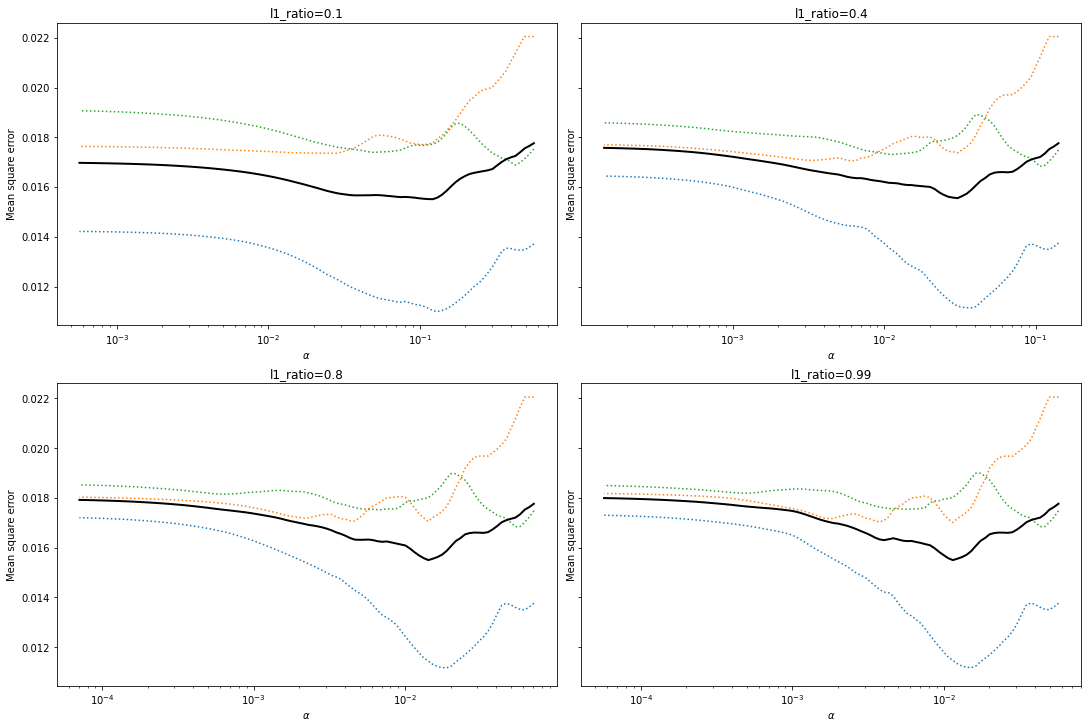

In [76]:
# displaying mean squared errors for various values of l1_ratio
# (values are over CV folds, thick black line is average over folds)
fig, axarr = plt.subplots(2, 2, figsize=(15, 10), 
                          constrained_layout=True, sharey=True)
for i, l1_ratio in enumerate(clf.l1_ratio):
    mse = clf.mse_path_[i]
    alphas = clf.alphas_[i]
    axarr.flat[i].semilogx(alphas, mse, ':')
    axarr.flat[i].semilogx(alphas, mse.mean(axis=-1), 'k',
                 label='Average across the folds', linewidth=2)

    axarr.flat[i].set_xlabel(r'$\alpha$')
    axarr.flat[i].set_ylabel('Mean square error')
    axarr.flat[i].set_title('l1_ratio=%s' % l1_ratio)

In [77]:
print("Optimal values for l1_ratio and alpha: %s, %.2e" % (clf.l1_ratio_, clf.alpha_))

Optimal values for l1_ratio and alpha: 0.99, 1.15e-02


How does the best l1_ratio evolve when n_informative_features increases ? Why ? 

# Intermediate part

## Classification data

Load some data verifying $y = \text{sign}(X \beta^\star)$ where $\beta^\star$ is unknown and $s$-sparse - but you do not know $s$. **The goal of this part is to infer $s$**.

In [127]:
data = loadmat("../../data/part3-data.mat")

In [128]:
X = data["X"]
y = data["Y"][:, 0]
print(X.shape, y.shape)
# TODO check numerically that y only contains values equal to 1 or -1
print("y only contains values equal to 1 or -1: ",len(y) == (len(y[y==1]) + len(y[y==-1])))

(100, 1000) (100,)
y only contains values equal to 1 or -1:  True


Now you must infer $s$.
A first possible approach is to use the Cross-Validation procedure used in the previous part: find the sparsity of the optimal $\beta$ obtained by cross-validation on a grid of values for $\alpha$ and l1_ratio.

In [129]:
# TODO find optimal s from a CV point of view
clf = ElasticNetCV(l1_ratio=[.1, .4, .8, .99,], cv=3, alphas=[.001, .001, .01, 1.0,], max_iter=5000)
clf.fit(X_train, y_train)
print("Optimal values for l1_ratio and alpha: %s, %.2e" % (clf.l1_ratio_, clf.alpha_))
print("sparsity: ", len(clf.coef_[clf.coef_>0]))

Optimal values for l1_ratio and alpha: 0.99, 1.00e-02
sparsity:  20


Another way to try to estimate $s$ is to measure the correlation between
the columns of $X$ and $y$. Indeed, the zero coefficients in $\beta^\star$ will ignore the
corresponding columns in $X$ while generating $y$. Can you also identify the indices of these features ?

In [144]:
np.where(clf.coef_==0)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27,  29,
         30,  31,  33,  34,  35,  36,  38,  39,  40,  41,  42,  43,  45,
         46,  47,  48,  50,  51,  52,  54,  55,  56,  57,  58,  59,  60,
         61,  62,  64,  65,  66,  67,  68,  69,  71,  72,  73,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 101, 103, 104, 105,
        106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        122, 123, 124, 126, 128, 129, 131, 132, 133, 134, 136, 138, 139,
        141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
        167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
        180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193,
        194, 195, 196, 197, 198, 199, 200, 202, 203

In [196]:
# TODO compute correlation

corr =[]
for i in range(X.shape[1]):
    corr.append(np.corrcoef(X[:,i], y, rowvar=False)[0,1])

In [206]:
# sort:
#idx = np.argsort(corr)
#plt.plot(corr[idx[::-1]])

In [115]:
# TODO identify the cutoff numerically, get s 
# and the indices of highest correlated features
highly_corr_feats =np.argmax(corr, axis=0)

Finally, use again the code of the first part, and tune the sparsity parameter l1_ratio so that
it selects only $s$ features ($s$ being your sparsity estimate from the previous
question). Look at which are the selected features in your solution. Do they
correspond to the ones you identified with the correlation approach? 
If they do not, can you figure out why does this happen?